<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/K1%2BK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import files
uploaded = files.upload()


Saving K1_sum.txt to K1_sum.txt


/tmp/ipython-input-831494159.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


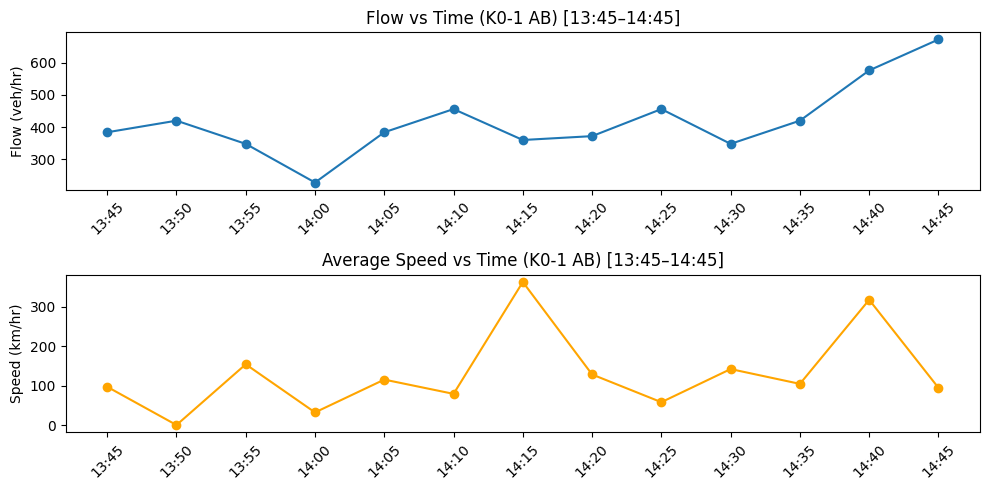

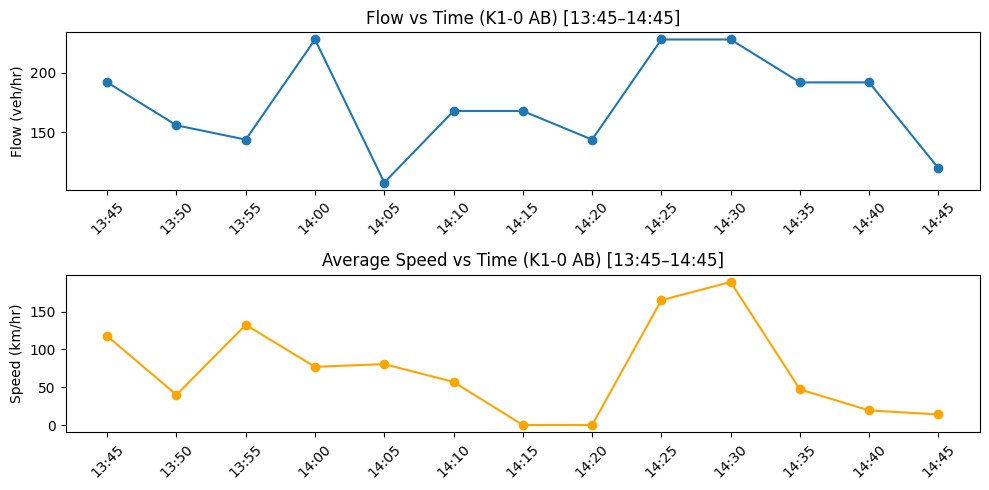

/tmp/ipython-input-831494159.py:136: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calc_phf(g["TotalVehicles"]))



=== PEAK HOUR FACTORS (13:45–14:45) ===
  Location Direction       PHF
0     K0-1        AB  0.755396
1     K1-0        AB  0.828704

=== VEHICLE COMPOSITION (K1+K2 Combined, 13:45–14:45) ===
StartTime  PrivatePct  HeavyPct
    13:45        96.0       4.0
    13:50       100.0       0.0
    13:55       100.0       0.0
    14:00       100.0       0.0
    14:05       100.0       0.0
    14:10       100.0       0.0
    14:15       100.0       0.0
    14:20       100.0       0.0
    14:25       100.0       0.0
    14:30       100.0       0.0
    14:35       100.0       0.0
    14:40       100.0       0.0
    14:45       100.0       0.0


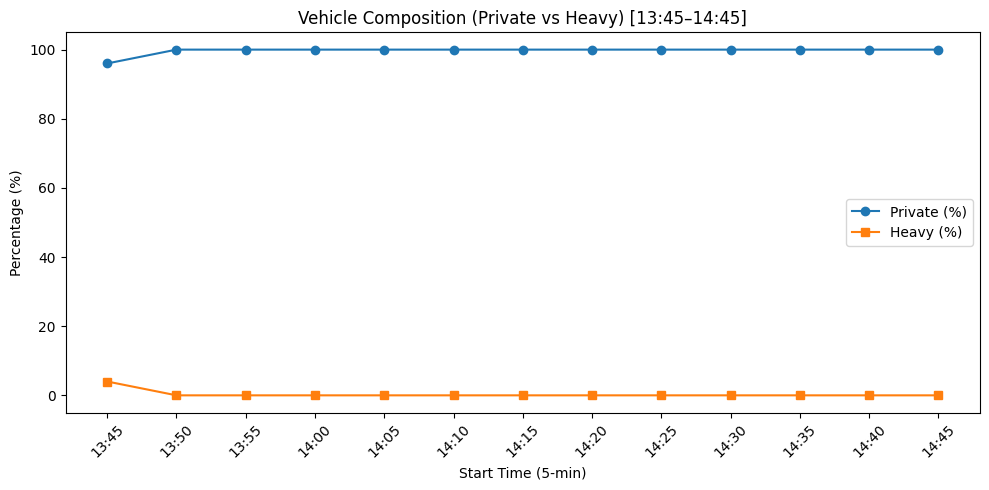


✅ Results saved as:
 - traffic_summary_filtered.csv
 - phf_results_filtered.csv
 - vehicle_percentages_filtered.csv


In [12]:
"""
Traffic Summary & Flow + Vehicle Composition Analysis (13:45–14:45)
-------------------------------------------------------------------
Processes tube data files (K1 & K2) for one hour (13:45–14:45):
a. Calculates % of private vs heavy vehicles (combined K1 + K2) per 5-min interval
b. Plots speeds & flows (veh/hr) for each direction at K1 & K2
c. Computes Peak Hour Factor (PHF) for each location/direction
"""

import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# === CONFIG ===
data_files = ["K1_sum.txt", "K2_sum.txt"]   # filenames for both locations
start_filter = "13:45"
end_filter = "14:45"

# === STEP 1: READ & PARSE BOTH FILES ===
all_records = []

block_pattern = re.compile(
    r"Channel Pair:\s*(\d+)\s*-\s*(\d+).*?"
    r"Report Period:\s*(\d{2}:\d{2})\s*to\s*(\d{2}:\d{2}).*?"
    r"Direction\s*([A-Z]{1,2}):.*?"
    r"VehType\s*Number\s*AvSpd.*?[-]+\s*(.*?)\s*[-]+\s*All Vehs\s*(.*?)\s*[-]+",
    re.DOTALL,
)

for filename in data_files:
    try:
        with open(filename, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()
    except FileNotFoundError:
        print(f"⚠️ File not found: {filename} — skipping.")
        continue

    for match in block_pattern.finditer(text):
        ch1, ch2, start, end, direction, veh_lines, all_line = match.groups()
        location = f"K{ch1}-{ch2}"

        for line in veh_lines.strip().splitlines():
            parts = re.split(r"\s+", line.strip())
            if len(parts) < 5:
                continue
            veh_type = parts[0]
            try:
                number = float(parts[1])
                avspd = float(parts[2])
                minspd = float(parts[3])
                maxspd = float(parts[4])
            except ValueError:
                continue
            if number > 500:
                continue

            all_records.append({
                "Location": location,
                "Direction": direction,
                "StartTime": start,
                "EndTime": end,
                "VehType": veh_type,
                "Number": number,
                "AvSpd": avspd,
                "MinSpd": minspd,
                "MaxSpd": maxspd,
            })

# === STEP 2: CREATE DATAFRAME ===
df = pd.DataFrame(all_records)
if df.empty:
    raise ValueError("No data found in any file.")

df["VehType"] = df["VehType"].str.replace("/", "_").str.strip()
df["StartTime_dt"] = pd.to_datetime(df["StartTime"], format="%H:%M")

# === STEP 3: FILTER 13:45–14:45 ===
start_t = datetime.strptime(start_filter, "%H:%M").time()
end_t = datetime.strptime(end_filter, "%H:%M").time()
df = df[(df["StartTime_dt"].dt.time >= start_t) & (df["StartTime_dt"].dt.time <= end_t)]

if df.empty:
    raise ValueError("No data found between 13:45 and 14:45.")

# === STEP 4: VEHICLE CATEGORIES ===
private_types = ["Cars", "Van/MPVs"]
heavy_types = ["Lorry/Buses", "Semis"]

# === STEP 5: FLOW & SPEED (Private Vehicles) ===
summary = (
    df[df["VehType"].isin(private_types)]
    .groupby(["Location", "Direction", "StartTime"])
    .apply(lambda x: pd.Series({
        "TotalVehicles": x["Number"].sum(),
        "AvSpeed": (x["AvSpd"] * x["Number"]).sum() / x["Number"].sum()
        if x["Number"].sum() > 0 else 0,
    }))
    .reset_index()
)
summary["Flow_veh_hr"] = summary["TotalVehicles"] * 12  # 5-min → hourly rate

# === STEP 6: PLOT SPEED & FLOW (per location/direction) ===
for loc in summary["Location"].unique():
    for direction in summary["Direction"].unique():
        subset = summary[(summary["Location"] == loc) & (summary["Direction"] == direction)]
        if subset.empty:
            continue

        plt.figure(figsize=(10, 5))
        plt.subplot(2, 1, 1)
        plt.plot(subset["StartTime"], subset["Flow_veh_hr"], marker="o")
        plt.title(f"Flow vs Time ({loc} {direction}) [13:45–14:45]")
        plt.ylabel("Flow (veh/hr)")
        plt.xticks(rotation=45)

        plt.subplot(2, 1, 2)
        plt.plot(subset["StartTime"], subset["AvSpeed"], marker="o", color="orange")
        plt.title(f"Average Speed vs Time ({loc} {direction}) [13:45–14:45]")
        plt.ylabel("Speed (km/hr)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# === STEP 7: PHF (Peak Hour Factor) ===
def calc_phf(flow_series):
    if len(flow_series) < 12:
        return None
    rolling_1h = flow_series.rolling(12).sum()
    peak_hour_flow = rolling_1h.max()
    peak_15min_flow = flow_series.rolling(3).sum().max()
    return (peak_hour_flow / (4 * peak_15min_flow)) if peak_15min_flow > 0 else None

phf_results = (
    summary.groupby(["Location", "Direction"])
    .apply(lambda g: calc_phf(g["TotalVehicles"]))
    .reset_index(name="PHF")
)
print("\n=== PEAK HOUR FACTORS (13:45–14:45) ===")
print(phf_results)

# === STEP 8: VEHICLE TYPE PERCENTAGES (K1 + K2 COMBINED) ===
combined = df.groupby(["StartTime", "VehType"])["Number"].sum().unstack(fill_value=0).reset_index()

# Ensure expected vehicle type columns exist
for vt in private_types + heavy_types:
    if vt not in combined.columns:
        combined[vt] = 0

combined["PrivateVehicles"] = combined[private_types].sum(axis=1)
combined["HeavyVehicles"] = combined[heavy_types].sum(axis=1)
combined["TotalVehicles"] = combined["PrivateVehicles"] + combined["HeavyVehicles"]
combined["PrivatePct"] = combined["PrivateVehicles"] / combined["TotalVehicles"] * 100
combined["HeavyPct"] = combined["HeavyVehicles"] / combined["TotalVehicles"] * 100

print("\n=== VEHICLE COMPOSITION (K1+K2 Combined, 13:45–14:45) ===")
print(combined[["StartTime", "PrivatePct", "HeavyPct"]].to_string(index=False))

# === STEP 9: PLOT VEHICLE PERCENTAGES ===
plt.figure(figsize=(10, 5))
plt.plot(combined["StartTime"], combined["PrivatePct"], marker="o", label="Private (%)")
plt.plot(combined["StartTime"], combined["HeavyPct"], marker="s", label="Heavy (%)")
plt.title("Vehicle Composition (Private vs Heavy) [13:45–14:45]")
plt.ylabel("Percentage (%)")
plt.xlabel("Start Time (5-min)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# === STEP 10: SAVE OUTPUT FILES ===
summary.to_csv("traffic_summary_filtered.csv", index=False)
phf_results.to_csv("phf_results_filtered.csv", index=False)
combined.to_csv("vehicle_percentages_filtered.csv", index=False)

print("\n✅ Results saved as:")
print(" - traffic_summary_filtered.csv")
print(" - phf_results_filtered.csv")
print(" - vehicle_percentages_filtered.csv")
